In [1]:
import itertools
import json
import logging
import os
import pickle
import unittest
from contextlib import contextmanager
from operator import itemgetter
from random import sample

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymatgen
from pymatgen.ext.matproj import MPRester
from pymatgen.core import Structure
from pandas.testing import assert_frame_equal, assert_series_equal
from pymatgen.analysis.structure_prediction.substitution_probability import SubstitutionProbability
from pymatgen.analysis.local_env import CrystalNN


import smact
from smact import Species
from smact.structure_prediction import prediction, database, mutation, probability_models, structure, utilities
from smact.structure_prediction.database import StructureDB
from smact.structure_prediction.mutation import CationMutator
from smact.structure_prediction.prediction import StructurePredictor
from smact.structure_prediction.structure import SmactStructure
from smact.structure_prediction.utilities import parse_spec, unparse_spec

from smact import Element,element_dictionary, ordered_elements, neutral_ratios
from smact.screening import smact_filter, pauling_test

from datetime import datetime
from pathos.multiprocessing import ProcessPool as Pool

m = MPRester("Z51OJasyeWwk4pci")

C:\Users\ashis\AppData\Local\Programs\Python\Python310\lib\site-packages\pymatgen\analysis\phase_diagram.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
C:\Users\ashis\AppData\Local\Programs\Python\Python310\lib\site-packages\pymatgen\ext\matproj.py:179: UserWarning: You are using the legacy MPRester, which is deprecated. If you are not a power user, ie., you do not have a lot of legacy code that uses many different MPRester methods, it is recommended you get a new API key from the new Materials Project front end. Once you use get your new API key, using the new API key will automatically route you to using the new MPRester.
  warnings.warn(


In [2]:
#Generate the dictionary of elements
all_el=element_dictionary(elements=ordered_elements(1,83)) #A dictionary of all element objects
symbols_list=list(all_el.keys())
all_els=[all_el[symbol] for symbol in symbols_list]
dont_want=["He","Ne","Ar","Kr","Xe","Pm","Tc"]

for unwanted in dont_want:
    symbols_list.remove(unwanted)
all_els=[all_el[symbol] for symbol in symbols_list]
coord_els=[el.coord_envs for el in all_els]

#Elements for A and B
A_els=[]
B_els=[]

for el in all_els:
        A_els.append(el)
        B_els.append(el)
print(f"The number of  allowed elements for (A) are: {len(A_els)} \n" )
print("The number of allowed elements for {B} are':" f"{len(B_els)} \n" )

The number of  allowed elements for (A) are: 76 

The number of allowed elements for {B} are':76 



In [3]:
#Generate the A-B combinations

AB_pairs = [(x,y) for x in A_els for y in B_els]

# Prove to ourselves that we have all unique chemical systems
print(f"We have generated {len(AB_pairs)} potential compounds")

We have generated 5776 potential compounds


In [4]:
def smact_filter(els, stoichs=[[1],[1]], species_unique=True):
    """Function that applies the charge neutrality and electronegativity
    tests in one go for simple application in external scripts that
    wish to apply the general 'smact test'.

    Args:
        els (tuple/list): A list of smact.Element objects
        threshold (int): Threshold for stoichiometry limit, default = 8
        species_unique (bool): Whether or not to consider elements in different
        oxidation states as unique in the results.
    Returns:
        allowed_comps (list): Allowed compositions for that chemical system
        in the form [(elements), (oxidation states), (ratios)] if species_unique=True
        or in the form [(elements), (ratios)] if species_unique=False.
    """
    compositions = []
    import itertools
    from smact import Element,element_dictionary, ordered_elements, neutral_ratios
    from smact.screening import smact_filter, pauling_test

    # Get symbols and electronegativities
    symbols = tuple(e.symbol for e in els)
    electronegs = [e.pauling_eneg for e in els]
    ox_combos = [e.oxidation_states for e in els]
    for ox_states in itertools.product(*ox_combos):
        # Test for charge balance
        cn_e, cn_r = neutral_ratios(ox_states, stoichs=stoichs)
        # Electronegativity test
        if cn_e:
            electroneg_OK = pauling_test(ox_states, electronegs)
            if electroneg_OK:
                for ratio in cn_r:
                    compositions.append(tuple([symbols,ox_states,ratio]))

    # Return list depending on whether we are interested in unique species combinations
    # or just unique element combinations.
    if species_unique:
        return compositions
    else:
        compositions = [(i[0], i[2]) for i in compositions]
        compositions = list(set(compositions))
        return compositions

In [5]:
# Use multiprocessing and smact_filter to quickly generate our list of compositions
start = datetime.now()
if __name__ == '__main__':   # Always use pool protected in an if statement
    with Pool(4) as p:    # start 4 worker processes
        result = p.map(smact_filter, AB_pairs)
print('Time taken to generate list:  {0}'.format(datetime.now()-start))

Time taken to generate list:  0:00:00.657527


In [6]:
# Flatten the list of lists
flat_list = [item for sublist in result for item in sublist]
print('Number of compositions: --> {0} <--'.format(len(flat_list)))
print('Each list entry looks like this:\n  elements, oxidation states, stoichiometries')
for i in flat_list[:5]:
    print(i)

Number of compositions: --> 4782 <--
Each list entry looks like this:
  elements, oxidation states, stoichiometries
(('H', 'Li'), (-1, 1), (1, 1))
(('H', 'Be'), (-1, 1), (1, 1))
(('H', 'B'), (-1, 1), (1, 1))
(('H', 'C'), (1, -1), (1, 1))
(('H', 'N'), (1, -1), (1, 1))


In [7]:
def comp_maker(comp):
    from pymatgen.core import Composition
    form = []
    for el, ammt in zip(comp[0], comp[2]):
        form.append(el)
        form.append(ammt)
    form = ''.join(str(e) for e in form)
    pmg_form = Composition(form).reduced_formula
    return pmg_form


if __name__ == '__main__':
    with Pool(4) as p:
        pretty_formulas = p.map(comp_maker, flat_list)

print('Each list entry now looks like this: ')
for i in pretty_formulas[:5]:
    print(i)

Each list entry now looks like this: 
LiH
BeH
BH
HC
HN


In [8]:
species=[]
A=[]
B=[]
for i in range(len(flat_list)):
    species.append(pretty_formulas[i])
    A.append((unparse_spec((flat_list[i][0][0],flat_list[i][1][0]))))
    B.append((unparse_spec((flat_list[i][0][1],flat_list[i][1][1]))))

columns=["Pretty Formula","A","B"]
df_list=[[species[i], A[i], B[i]] for i in range(len(species))]
df=pd.DataFrame(data=df_list, columns=columns)
df=df.reset_index(drop=True)

#Keeping only the cations in Column A and Anions in Column B
df= df[df['A'].str.contains('\+')]
df.to_csv('Comps_control.csv', index=False)
comps = pd.read_csv('Comps_control.csv')
comps.head()

,Pretty Formula,A,B
0,HC,H1+,C1-
1,HN,H1+,N1-
2,H2O2,H1+,O1-
3,HF,H1+,F1-
4,HS,H1+,S1-


In [9]:
#This creates database object
DB=StructureDB("Structure_Database.db")

#These create tables within the database, uncomment the next line if creating new table in a new database
#DB.add_table("Experimental")

In [10]:
#Using default lambda values, instantiate Cation Mutator and Structure Predictor
CM=CationMutator.from_json()
SP=StructurePredictor(CM, DB, "Experimental")

In [11]:
#Checking if compositions exist in the probability dataframe and then using Structure Predictor on a list of test compositions
cond_df = CM.complete_cond_probs()
ions = list(cond_df.columns)

comps_copy = comps[['A', 'B']]

df_copy_bool = comps_copy.isin(ions)
x = comps_copy[df_copy_bool].fillna(0)
x = x[x.A != 0]
x = x[x.B != 0]
x = x.reset_index(drop=True)
inner_merged=pd.merge(x, comps)
#Create a list of test species
test_specs_list=[[parse_spec(inner_merged["A"][i]),parse_spec(inner_merged["B"][i])] for i in range(inner_merged.shape[0])]

#Set up a for loop to store
from datetime import datetime
start = datetime.now()
from operator import itemgetter
preds=[]
parents_list=[]
probs_list=[]
for test_specs in test_specs_list:
    predictions=list(SP.predict_structs(test_specs, thresh=10e-4, include_same=False ))
    predictions.sort(key=itemgetter(1), reverse=True)
    parents = [x[2].composition() for x in predictions]
    probs = [x[1] for x in predictions]
    preds.append(predictions)
    parents_list.append(parents)
    probs_list.append(probs)
print(f"Time taken to predict the crystal structures of our search space of {inner_merged.shape[0]} with a threshold of 0.0001 is {datetime.now()-start} ")
#print(parents_list)
print("")
#print(probs_list)

Time taken to predict the crystal structures of our search space of 269 with a threshold of 0.0001 is 0:00:01.336073 



In [12]:
#Storing and filtering the results in dataframe
pred_structs = []
probs = []
parent_structs = []
parent_pretty_formula = []
for i in preds:
    if len(i) == 0:
        pred_structs.append(None)
        probs.append(None)
        parent_structs.append(None)
        parent_pretty_formula.append(None)
    else:
        pred_structs.append(i[0][0].as_poscar())
        probs.append(i[0][1])
        parent_structs.append(i[0][2].as_poscar())
        parent_pretty_formula.append(Structure.from_str(i[0][2].as_poscar(), fmt="poscar").composition.reduced_formula)

#add results to dataframe
inner_merged["predicted_structure"] = pred_structs
inner_merged["probability"] = probs
inner_merged["Parent formula"] = parent_pretty_formula
inner_merged["parent_structure"] = parent_structs
results=inner_merged.dropna()
results=results.reset_index(drop=True)
results.head()

,A,B,Pretty Formula,predicted_structure,probability,Parent formula,parent_structure
0,H1+,F1-,HF,F1- H1+\n1.0\n2.656991 -3.486846 0.0\n2.656991...,0.168561,HCl,Cl1- H1+\n1.0\n2.656991 -3.486846 0.0\n2.65699...
1,H1+,Cl1-,HCl,Cl1- H1+\n1.0\n6.160672 6.203084 0.0\n-6.16067...,0.228937,HI,H1+ I1-\n1.0\n6.160672 6.203084 0.0\n-6.160672...
2,H1+,Br1-,HBr,Br1- H1+\n1.0\n6.160672 6.203084 0.0\n-6.16067...,0.177099,HI,H1+ I1-\n1.0\n6.160672 6.203084 0.0\n-6.160672...
3,H1+,I1-,HI,H1+ I1-\n1.0\n2.785687 -3.663721 0.0\n2.785687...,0.138700,HBr,Br1- H1+\n1.0\n2.785687 -3.663721 0.0\n2.78568...
4,Li1+,F1-,LiF,F1- Li1+\n1.0\n0.0 2.576374 2.576374\n2.576374...,0.168561,LiCl,Cl1- Li1+\n1.0\n0.0 2.576374 2.576374\n2.57637...


In [13]:
#Validating the predicted coordination numbers with the 536 experimental coordination numbers in the database

prediction_accuracy = []
CN_exp = []
CN_pred = []
crystal = CrystalNN()
for ind in results.index:
    comp = SmactStructure.from_poscar(results['predicted_structure'][ind]).composition()
    experimental_structure = DB.get_structs(comp,'Experimental')
    if len(experimental_structure)!=0:
        experimental_structure = Structure.from_str(experimental_structure[0].as_poscar(), fmt='poscar')
        cn_exp = crystal.get_cn(experimental_structure, n=0)
        predicted_structure = Structure.from_str(results['predicted_structure'][ind], fmt='poscar')
        cn_pred = crystal.get_cn(predicted_structure, n=0)

        CN_exp.append(cn_exp)
        CN_pred.append(cn_pred)

        if cn_exp == cn_pred:
            prediction_accuracy.append('Correct')
        else:
            prediction_accuracy.append('Incorrect')

success_percent = (prediction_accuracy.count('Correct')/len(prediction_accuracy))*100
print(f'The prediction accuracy is {success_percent}%')

C:\Users\ashis\AppData\Local\Programs\Python\Python310\lib\site-packages\pymatgen\analysis\local_env.py:4121: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
C:\Users\ashis\AppData\Local\Programs\Python\Python310\lib\site-packages\pymatgen\analysis\local_env.py:3924: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(


The prediction accuracy is 69.89247311827957%


In [14]:
#filtering results to include only those that match structures in the Database

in_db=[]
for i in results["predicted_structure"]:
    comp_=SmactStructure.from_poscar(i).composition()
    if len(DB.get_structs(comp_, "Experimental"))!=0:
        in_db.append("Yes")
    else:
        in_db.append("No")
results["In DB?"]=in_db

filtered_results = results[results['In DB?']=='Yes']
filtered_results = filtered_results.reset_index(drop=True)
filtered_results['Experimental CN'] = CN_exp
filtered_results['Predicted CN'] = CN_pred
filtered_results['Validation'] = prediction_accuracy
filtered_results.to_csv('Data-mined_lambda_results.csv')
filtered_results.head()

,A,B,Pretty Formula,predicted_structure,probability,Parent formula,parent_structure,In DB?,Experimental CN,Predicted CN,Validation
0,H1+,F1-,HF,F1- H1+\n1.0\n2.656991 -3.486846 0.0\n2.656991...,0.168561,HCl,Cl1- H1+\n1.0\n2.656991 -3.486846 0.0\n2.65699...,Yes,1,1,Correct
1,H1+,Cl1-,HCl,Cl1- H1+\n1.0\n6.160672 6.203084 0.0\n-6.16067...,0.228937,HI,H1+ I1-\n1.0\n6.160672 6.203084 0.0\n-6.160672...,Yes,1,1,Correct
2,H1+,Br1-,HBr,Br1- H1+\n1.0\n6.160672 6.203084 0.0\n-6.16067...,0.177099,HI,H1+ I1-\n1.0\n6.160672 6.203084 0.0\n-6.160672...,Yes,1,1,Correct
3,H1+,I1-,HI,H1+ I1-\n1.0\n2.785687 -3.663721 0.0\n2.785687...,0.138700,HBr,Br1- H1+\n1.0\n2.785687 -3.663721 0.0\n2.78568...,Yes,1,2,Incorrect
4,Li1+,F1-,LiF,F1- Li1+\n1.0\n0.0 2.576374 2.576374\n2.576374...,0.168561,LiCl,Cl1- Li1+\n1.0\n0.0 2.576374 2.576374\n2.57637...,Yes,6,6,Correct


<Figure size 12000x8000 with 0 Axes>

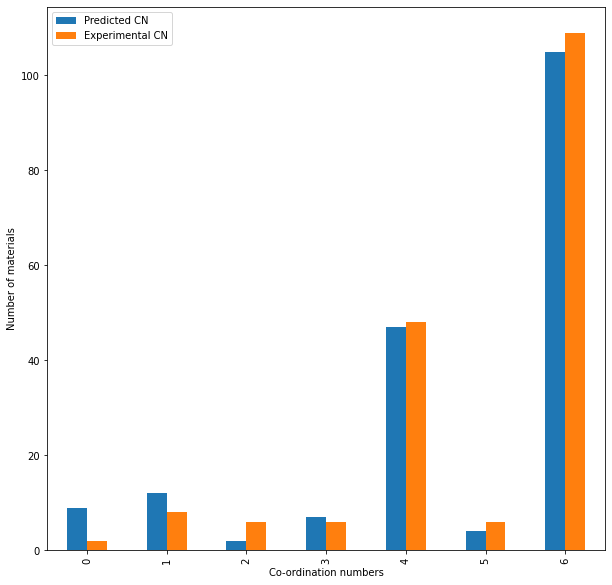

In [15]:
#for visualising the predicted co-ordination numbers

import matplotlib.pyplot as plt

cn_df = filtered_results[['Experimental CN', 'Predicted CN']]
temp1 = pd.DataFrame(cn_df['Experimental CN'].value_counts())
temp1.index.name = 'Co-ordination numbers'
temp2 = pd.DataFrame(cn_df['Predicted CN'].value_counts())
temp2.index.name = 'Co-ordination numbers'
for_plot = temp2.merge(temp1, how='left', left_on='Co-ordination numbers', right_on='Co-ordination numbers')
indices = list(range(len(for_plot)))
for_plot['index'] = indices
for_plot = for_plot.reset_index()
del for_plot['index']
for_plot = for_plot.sort_values('Co-ordination numbers', ascending = True).reset_index(drop=True)
mpl.rc_file_defaults()
plt.rcParams.update({'font.size': 15})
plt.figure(dpi = 2000)
for_plot.plot(x = 'Co-ordination numbers', y=['Predicted CN','Experimental CN'], kind='bar', figsize = (10,10), ylabel = 'Number of materials')
plt.savefig('Results_default.pdf')

In [16]:
#using shannon radii model
CM = CationMutator.from_json('sr_lambda.json')
SP=StructurePredictor(CM, DB, "Experimental")

In [17]:
#Checking if compositions exist in the probability dataframe and then using Structure Predictor on a list of test compositions
cond_df = CM.complete_cond_probs()
ions = list(cond_df.columns)

comps_copy = comps[['A', 'B']]

df_copy_bool = comps_copy.isin(ions)
x = comps_copy[df_copy_bool].fillna(0)
x = x[x.A != 0]
x = x[x.B != 0]
x = x.reset_index(drop=True)
inner_merged=pd.merge(x, comps)

In [18]:
#Create a list of test species
test_specs_list=[[parse_spec(inner_merged["A"][i]),parse_spec(inner_merged["B"][i])] for i in range(inner_merged.shape[0])]

#Set up a for loop to store
from datetime import datetime
start = datetime.now()
from operator import itemgetter
preds=[]
parents_list=[]
probs_list=[]
for test_specs in test_specs_list:
    predictions=list(SP.predict_structs(test_specs, thresh=10e-4, include_same=False ))
    predictions.sort(key=itemgetter(1), reverse=True)
    parents = [x[2].composition() for x in predictions]
    probs = [x[1] for x in predictions]
    preds.append(predictions)
    parents_list.append(parents)
    probs_list.append(probs)
print(f"Time taken to predict the crystal structures of our search space of {inner_merged.shape[0]} with a threshold of 0.0001 is {datetime.now()-start} ")
#print(parents_list)
print("")
#print(probs_list)

Time taken to predict the crystal structures of our search space of 196 with a threshold of 0.0001 is 0:00:01.152517 



In [19]:
#Storing and filtering the results in dataframe
pred_structs = []
probs = []
parent_structs = []
parent_pretty_formula = []
for i in preds:
    if len(i) == 0:
        pred_structs.append(None)
        probs.append(None)
        parent_structs.append(None)
        parent_pretty_formula.append(None)
    else:
        pred_structs.append(i[0][0].as_poscar())
        probs.append(i[0][1])
        parent_structs.append(i[0][2].as_poscar())
        parent_pretty_formula.append(Structure.from_str(i[0][2].as_poscar(), fmt="poscar").composition.reduced_formula)

#add results to dataframe
inner_merged["predicted_structure"] = pred_structs
inner_merged["probability"] = probs
inner_merged["Parent formula"] = parent_pretty_formula
inner_merged["parent_structure"] = parent_structs
results=inner_merged.dropna()
results=results.reset_index(drop=True)
results.head()

,A,B,Pretty Formula,predicted_structure,probability,Parent formula,parent_structure
0,H1+,F1-,HF,F1- H1+\n1.0\n6.160672 6.203084 0.0\n-6.160672...,0.009866,HI,H1+ I1-\n1.0\n6.160672 6.203084 0.0\n-6.160672...
1,H1+,Cl1-,HCl,Cl1- H1+\n1.0\n6.160672 6.203084 0.0\n-6.16067...,0.010865,HI,H1+ I1-\n1.0\n6.160672 6.203084 0.0\n-6.160672...
2,H1+,Br1-,HBr,Br1- H1+\n1.0\n6.160672 6.203084 0.0\n-6.16067...,0.011019,HI,H1+ I1-\n1.0\n6.160672 6.203084 0.0\n-6.160672...
3,H1+,I1-,HI,H1+ I1-\n1.0\n2.785687 -3.663721 0.0\n2.785687...,0.010154,HBr,Br1- H1+\n1.0\n2.785687 -3.663721 0.0\n2.78568...
4,Li1+,F1-,LiF,F1- Li1+\n1.0\n2.283037 -3.954335 0.0\n2.28303...,0.009866,LiI,I1- Li1+\n1.0\n2.283037 -3.954335 0.0\n2.28303...


In [20]:
#Validating the predicted coordination numbers with the 536 experimental coordination numbers in the database

prediction_accuracy = []
CN_exp = []
CN_pred = []
crystal = CrystalNN()
for ind in results.index:
    comp = SmactStructure.from_poscar(results['predicted_structure'][ind]).composition()
    experimental_structure = DB.get_structs(comp,'Experimental')
    if len(experimental_structure)!=0:
        experimental_structure = Structure.from_str(experimental_structure[0].as_poscar(), fmt='poscar')
        cn_exp = crystal.get_cn(experimental_structure, n=0)
        predicted_structure = Structure.from_str(results['predicted_structure'][ind], fmt='poscar')
        cn_pred = crystal.get_cn(predicted_structure, n=0)

        CN_exp.append(cn_exp)
        CN_pred.append(cn_pred)

        if cn_exp == cn_pred:
            prediction_accuracy.append('Correct')
        else:
            prediction_accuracy.append('Incorrect')

success_percent = (prediction_accuracy.count('Correct')/len(prediction_accuracy))*100
print(f'The prediction accuracy is {success_percent}%')

C:\Users\ashis\AppData\Local\Programs\Python\Python310\lib\site-packages\pymatgen\analysis\local_env.py:4121: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
C:\Users\ashis\AppData\Local\Programs\Python\Python310\lib\site-packages\pymatgen\analysis\local_env.py:3924: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(


The prediction accuracy is 52.976190476190474%


In [21]:
#filtering results to include only those that match structures in the Database

in_db=[]
for i in results["predicted_structure"]:
    comp_=SmactStructure.from_poscar(i).composition()
    if len(DB.get_structs(comp_, "Experimental"))!=0:
        in_db.append("Yes")
    else:
        in_db.append("No")
results["In DB?"]=in_db

filtered_results = results[results['In DB?']=='Yes']
filtered_results = filtered_results.reset_index(drop=True)
filtered_results['Experimental CN'] = CN_exp
filtered_results['Predicted CN'] = CN_pred
filtered_results['Validation'] = prediction_accuracy
filtered_results.to_csv('shannon_radii_results.csv')

<Figure size 12800x9600 with 0 Axes>

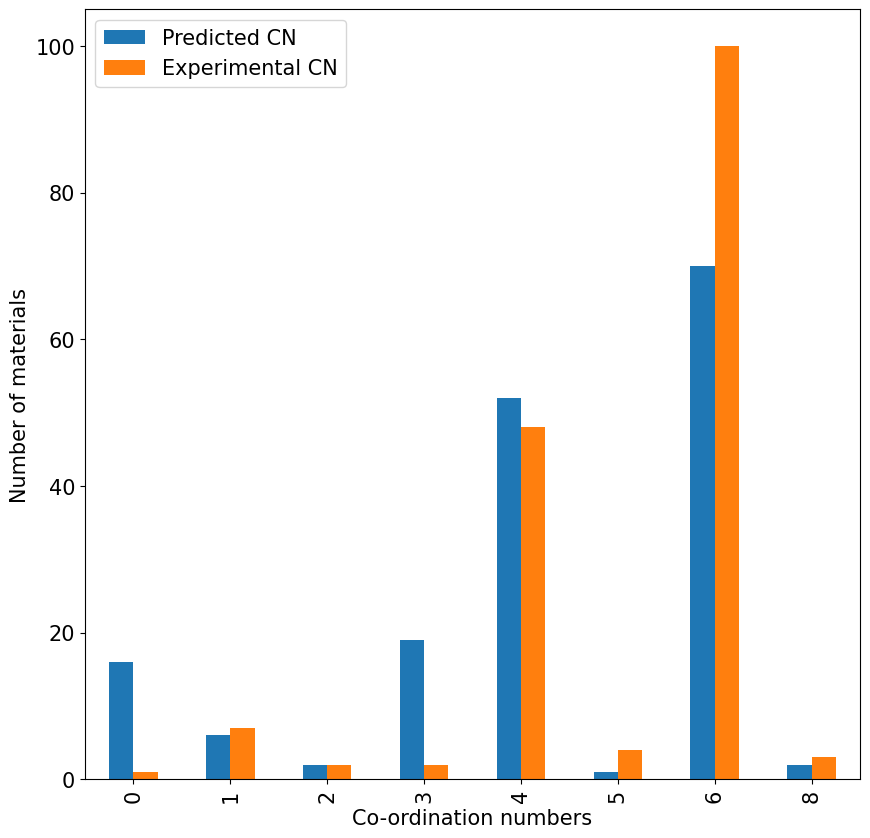

In [22]:
#for visualising the predicted co-ordination numbers

import matplotlib.pyplot as plt

cn_df = filtered_results[['Experimental CN', 'Predicted CN']]
temp1 = pd.DataFrame(cn_df['Experimental CN'].value_counts())
temp1.index.name = 'Co-ordination numbers'
temp2 = pd.DataFrame(cn_df['Predicted CN'].value_counts())
temp2.index.name = 'Co-ordination numbers'
for_plot = temp2.merge(temp1, how='left', left_on='Co-ordination numbers', right_on='Co-ordination numbers')
indices = list(range(len(for_plot)))
for_plot['index'] = indices
for_plot = for_plot.reset_index()
del for_plot['index']
for_plot = for_plot.sort_values('Co-ordination numbers', ascending = True).reset_index(drop=True)
mpl.rc_file_defaults()
plt.rcParams.update({'font.size': 15})
plt.figure(dpi = 2000)
for_plot.plot(x = 'Co-ordination numbers', y=['Predicted CN','Experimental CN'], kind='bar', figsize = (10,10), ylabel = 'Number of materials' )
plt.xticks(rotation=90)
plt.savefig('Results_radii.pdf')

In [23]:
df1 = pd.read_csv('Data-mined_lambda_results.csv')
df2 = pd.read_csv('shannon_radii_results.csv')

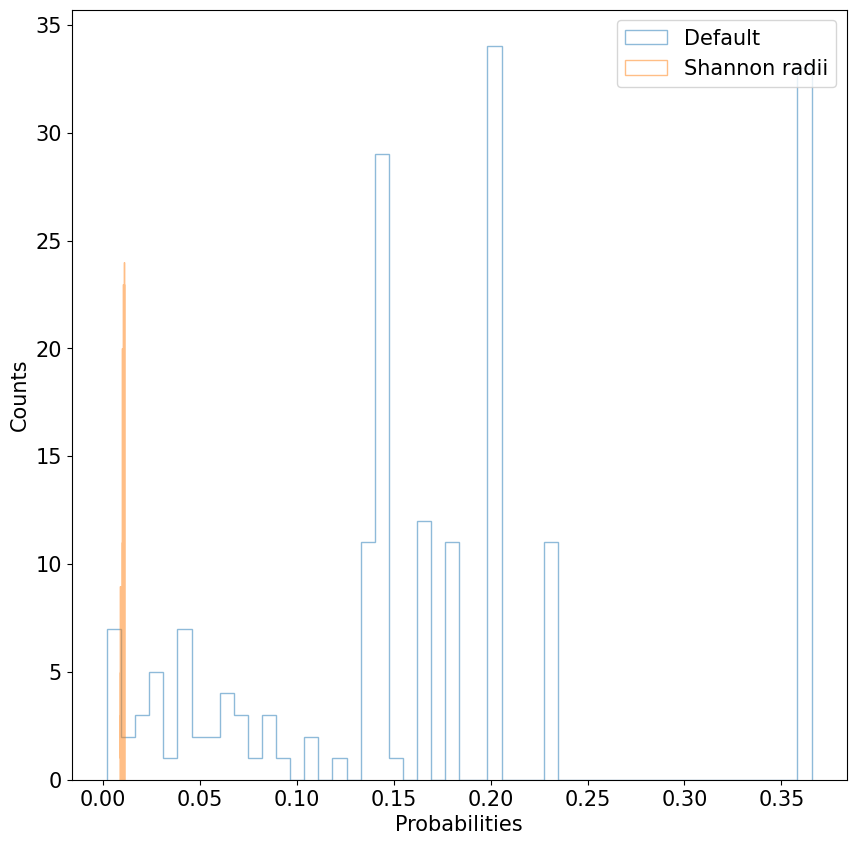

In [24]:
plt.figure(figsize=(10,10))
plt.hist(df1['probability'], bins=50, alpha=0.5, label='Default', histtype='step')
plt.hist(df2['probability'], bins=50, alpha=0.5, label='Shannon radii', histtype='step')
plt.legend()
plt.xlabel('Probabilities')
plt.ylabel('Counts')
plt.savefig('Control_probs_compare.pdf')